# Tweet Sentiment Analysis
---

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json

#Import WordCloud
from wordcloud import WordCloud, STOPWORDS
from scipy import stats

In [3]:
# Remove unwanted patterns
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tywang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tywang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

#from sklearn.cross_validation import StratifiedKFold, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve

In [5]:
# Tweet Cleaner
stopwordlist = set(stopwords.words("english"))
wordnet_lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

with open('ShortendText.json','r') as file:
    slang_dict=json.loads(file.read())

def remove_stopwords(tweet):
    new_tweet = [w for w in tweet.split() if not w in stopwordlist] 
    return (" ").join(new_tweet) 

def remove_specialchar(tweet):
    #Converts HTML tags to the characters they represent
    soup = BeautifulSoup(tweet, "html.parser")
    tweet = soup.get_text()
    
    #Convert www.* or https?://* to empty strings
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet) 
    #Convert @username to empty strings
    tweet = re.sub('@[^\s]+','',tweet)

    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    tweet = re.sub('[\n]+', ' ', tweet)
    
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    
    #Trims the tweet
    tweet = tweet.strip('\'"')
    
    #Remove all char not alphabets, num or whitespaces
    tweet = re.sub('[^A-Za-z ]+','', tweet)
    
    return tweet

# def convert_emoticons(tweet):
#     for emot in EMOTICONS:
#         tweet = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
#     return tweet

#Attempts to replace every individual word with it's root word.
def stemmer_lemmatizer(tweet):
    word_list = []
    for word in tweet.split():
        word = ps.stem(word)
        word = wordnet_lemmatizer.lemmatize(word)
        word_list.append(word)
    return (" ".join(word_list))

#for testing
#Tweets = df_oba['Tweet'].values
#for i in range(len(Tweets)):
#    print(i)
#    b = remove_specialchar(Tweets[i])
#    a = stemmer_lemmatizer(b)
#    print('last', a)
#    print('last', remove_stopwords(a))

def lookup_dict(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
    return text

In [6]:
abbr_dict={
    "what's":"what is",
    "what're":"what are",
    "who's":"who is",
    "who're":"who are",
    "where's":"where is",
    "where're":"where are",
    "when's":"when is",
    "when're":"when are",
    "how's":"how is",
    "how're":"how are",

    "i'm":"i am",
    "we're":"we are",
    "you're":"you are",
    "they're":"they are",
    "it's":"it is",
    "he's":"he is",
    "she's":"she is",
    "that's":"that is",
    "there's":"there is",
    "there're":"there are",
    
    "i've":"i have",
    "we've":"we have",
    "you've":"you have",
    "they've":"they have",
    "who've":"who have",
    "would've":"would have",
    "not've":"not have",

    "i'll":"i will",
    "we'll":"we will",
    "you'll":"you will",
    "he'll":"he will",
    "she'll":"she will",
    "it'll":"it will",
    "they'll":"they will",

    "isn't":"is not",
    "wasn't":"was not",
    "aren't":"are not",
    "weren't":"were not",
    "can't":"can not",
    "couldn't":"could not",
    "don't":"do not",
    "didn't":"did not",
    "shouldn't":"should not",
    "wouldn't":"would not",
    "doesn't":"does not",
    "haven't":"have not",
    "hasn't":"has not",
    "hadn't":"had not",
    "won't":"will not",
    #punctuation:'',
    '\s+':' ', # replace multi space with one single space
}

In [7]:
def load_csv():
    xls = pd.ExcelFile('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/training-Obama-Romney-tweets.xlsx')
    df1 = pd.read_excel(xls, 'Obama')
    df2 = pd.read_excel(xls, 'Romney')
    return df1, df2

def data_parse(df):
    
    #drop missing values and rename columns
    df = df.iloc[1:, 3:5]
    df = df.rename(columns = {'Anootated tweet':'Tweet', 'Unnamed: 4': 'Class'})
    # Drop rows if Tweet is empty
    df.dropna(subset = ['Tweet'], inplace=True)
    print(df.shape)
    
    #dtype class label
    df['Class'] = df['Class'].astype(str)
    df['Tweet'] = df['Tweet'].astype(str)
    print(df.info())
    print(df['Class'].value_counts())

    # Extract rows where class labels -1, 0, 1
    df = df[ (df['Class'] == '0') |(df['Class'] == '-1') | (df['Class'] == '1') ]
    print('After extracting:', df.shape)
    
    tweets = df['Tweet'].values
    targets = df['Class'].values
    
    return tweets, targets

def tweet_cleaning(tweets, flag):
    
    for i in range(len(tweets)):
        #print(i)
        #print('original:', tweets[i])
        tweets[i] = tweets[i].lower()
        # if tweets[i] in slang_dict.keys():
        #    tweets[i].replace(slang_dict,regex=True,inplace=True)
        # if tweets[i] in abbr_dict.keys():
        #    tweets[i].replace(abbr_dict,regex=True,inplace=True)
        
        #tweets[i] = ' '.join(filter(lambda x: x.isalpha(), ''.join(tweets[i])))
        tweets[i] = remove_specialchar(tweets[i])
        if flag == 'stem_lem':
            tweets[i] = stemmer_lemmatizer(tweets[i])
        if flag == 'rm_stopwords':
            tweets[i] = remove_stopwords(tweets[i])
        if flag == 'all':
            tmp = remove_specialchar(tweets[i])
            tmp = stemmer_lemmatizer(tmp)
            tweets[i] = remove_stopwords(tmp)
        #tmp = remove_specialchar(tweets[i])
        #tmp = stemmer_lemmatizer(tmp)
        #tweets[i] = remove_stopwords(tmp)
        #print('final:', tweets[i])
    return tweets

In [8]:
# tweets_oba[10]

In [9]:
def save_dataset(tweets, targets, tw_name, tar_name):
    print('Saving training dataset...')
    
    #Create Saving Files
    if not os.path.exists('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/TrainData'):
        os.makedirs('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/TrainData')
        
    np.save('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/TrainData/' + tw_name + '.npy', tweets)
    np.save('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/TrainData/' + tar_name + '.npy', targets)

    print('Saved parsed dataset')
    

In [10]:
def wordcloud(data,backgroundcolor = 'white', width = 400, height = 150):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [11]:
df1, df2 = load_csv()

## Obama's Tweets

In [12]:

tweets_oba, targets_oba = data_parse(df1)
tweets_oba.shape, targets_oba.shape

(7196, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7196 entries, 1 to 7198
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   7196 non-null   object
 1   Class   7196 non-null   object
dtypes: object(2)
memory usage: 168.7+ KB
None
0             1977
-1            1968
1             1679
2             1543
irrevelant      23
nan              5
irrelevant       1
Name: Class, dtype: int64
After extracting: (5624, 2)


((5624,), (5624,))

In [13]:
#Apply Custom Dictionary
print(tweets_oba)
tweet_cleaning(tweets_oba, '')
df_oba = pd.DataFrame({'tweet':tweets_oba,'label':targets_oba})
# df_oba['tweet'] = df_oba['tweet'].apply(lambda x: lookup_dict(x,slang_dict))
df_oba['tweet'] = df_oba['tweet'].apply(lambda x: lookup_dict(x,abbr_dict))
df_oba.to_csv('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/TrainData/parsed_tweets_oba.csv')
tweets_oba = df_oba['tweet']
print(tweets_oba)

["Kirkpatrick, who wore a baseball cap embroidered with Barack Obama's signature and had the hangdog look of Jason segel - Courier Journal"
 '#<e>obama</e> debates that Cracker Ass Cracker tonight... I will be tuned in! #TeamObama'
 '@Hollivan @hereistheanswer  Youre missing the point  Im afraid you do not understand the bigger picture if you dont care if Obama re elected'
 ...
 ' The Reason <e>Ann Romney</e> And <e>Michelle Obama</e> Matched <a>Last Night</a>: <e>Michelle Obama</e> and <e>Ann Romney</e> showed up to last nig... http://t.co/lRXmH4Ka                           '
 ' <e>Obama</e> Kenakan Cincin Syahadat Sejak SMA? http://t.co/HQw4rfqx                           '
 ' Bitches be like "Obama<3" bitches just want <a>food stamps</a> lmao _Ù÷â                           ']
0       kirkpatrick who wore a baseball cap embroidere...
1       obama debates that cracker ass cracker tonight...
2        youre missing the point im afraid you do not ...
3       i was raised as a democrat le

## WordCloud for Oba_Tweet

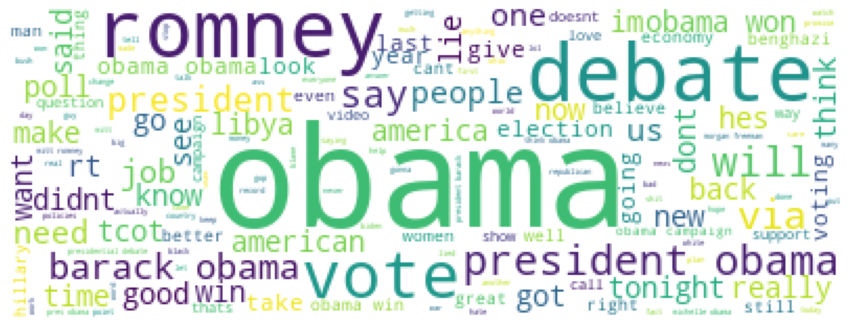

In [14]:
#Original Tweet
wordcloud(''.join(tweets_oba))

0       kirkpatrick who wore a baseball cap embroidere...
1       obama debates that cracker ass cracker tonight...
2        youre missing the point im afraid you do not ...
3       i was raised as a democrat left the party year...
4       the obama camp cant afford to lower expectatio...
                              ...                        
5619     except for women who work in the wh they make...
5620     days to election selection elect lewis ken ha...
5621     the reason ann romney and michelle obama matc...
5622             obama kenakan cincin syahadat sejak sma 
5623     bitches be like obama bitches just want food ...
Name: tweet, Length: 5624, dtype: object


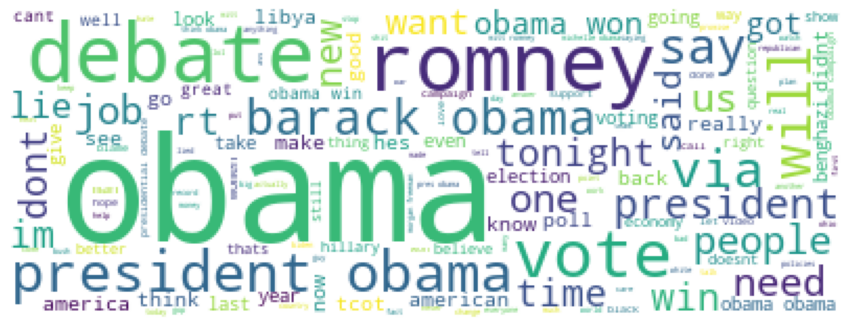

In [15]:
# Remove special char only
oba_rmspecial = tweet_cleaning(tweets_oba, '')
print(oba_rmspecial)
wordcloud(''.join(oba_rmspecial))

0       kirkpatrick who wore a basebal cap embroid wit...
1       obama debat that cracker as cracker tonight i ...
2       your miss the point im afraid you do not under...
3       i wa rais a a democrat left the parti year ago...
4       the obama camp cant afford to lower expect for...
                              ...                        
5619    except for woman who work in the wh they make ...
5620    day to elect select elect lewi ken hall mha na...
5621    the reason ann romney and michel obama match l...
5622              obama kenakan cincin syahadat sejak sma
5623    bitch be like obama bitch just want food stamp...
Name: tweet, Length: 5624, dtype: object


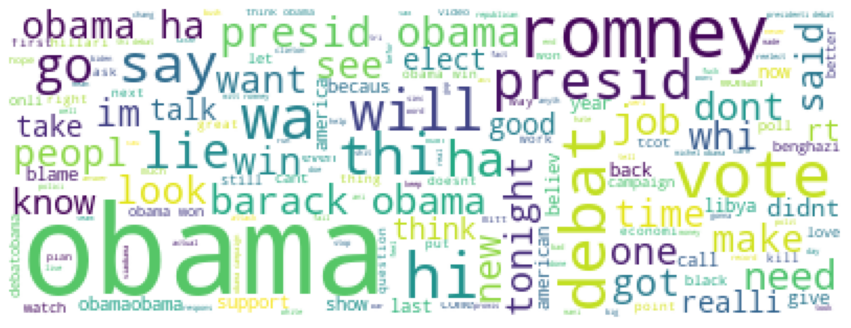

In [16]:
# Tweet stemmer_lemmatizer
oba_stemlem = tweet_cleaning(tweets_oba, 'stem_lem')
print(oba_stemlem)
wordcloud(''.join(oba_stemlem))

0       kirkpatrick wore basebal cap embroid barack ob...
1       obama debat cracker cracker tonight tune teamo...
2       miss point im afraid understand bigger pictur ...
3       wa rais democrat left parti year ago lifetim n...
4       obama camp cant afford lower expect tonight de...
                              ...                        
5619    except woman work wh make le honest yup obama ...
5620    day elect select elect lewi ken hall mha natio...
5621    reason ann romney michel obama match last nigh...
5622              obama kenakan cincin syahadat sejak sma
5623          bitch like obama bitch want food stamp lmao
Name: tweet, Length: 5624, dtype: object


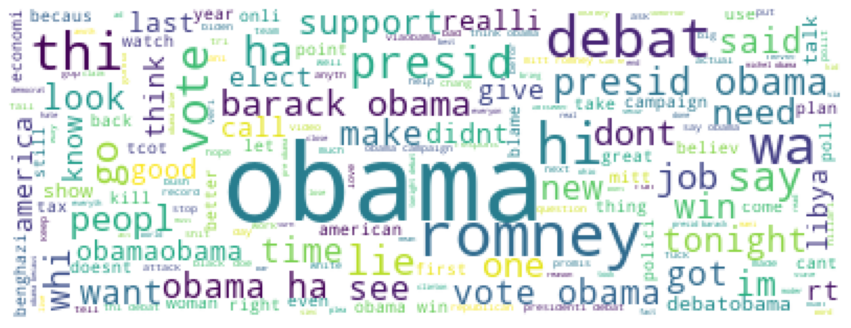

In [17]:
# Remove stopword
oba_rmstop = tweet_cleaning(tweets_oba, 'rm_stopwords')
print(oba_rmstop)
wordcloud(''.join(oba_rmstop))

0       kirkpatrick wore baseb cap embroid barack obam...
1       obama debat cracker cracker tonight tune teamo...
2       miss point im afraid understand bigger pictur ...
3       wa rai democrat left parti year ago lifetim ne...
4       obama camp cant afford lower expect tonight de...
                              ...                        
5619    except woman work wh make le honest yup obama ...
5620    day elect select elect lewi ken hall mha natio...
5621    reason ann romney michel obama match last nigh...
5622              obama kenakan cincin syahadat sejak sma
5623          bitch like obama bitch want food stamp lmao
Name: tweet, Length: 5624, dtype: object


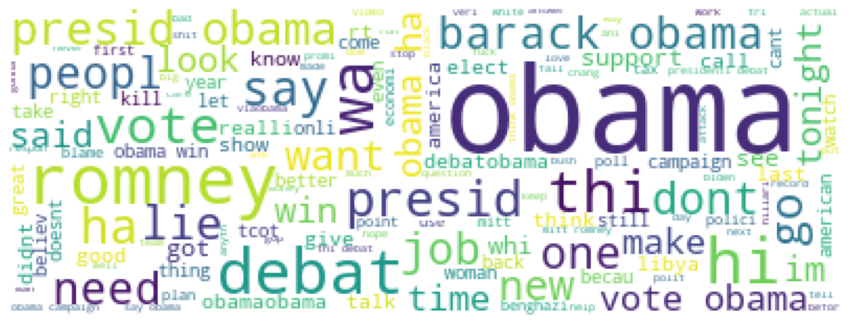

In [18]:
# All cleaning methods
oba_cleanall = tweet_cleaning(tweets_oba, 'all')
print(oba_cleanall)
wordcloud(''.join(oba_cleanall))

In [19]:
save_dataset(oba_cleanall, targets_oba, 'tweets_oba', 'targets_oba')

Saving training dataset...
Saved parsed dataset


## Romney's Tweets

In [20]:
tweets_rom, targets_rom = data_parse(df2)
tweets_rom.shape, targets_rom.shape

(7200, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200 entries, 1 to 7200
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   7200 non-null   object
 1   Class   7200 non-null   object
dtypes: object(2)
memory usage: 168.8+ KB
None
-1      2893
0       1680
2       1351
1       1075
!!!!     169
nan       29
IR         3
Name: Class, dtype: int64
After extracting: (5648, 2)


((5648,), (5648,))

In [21]:
tweets_rom
# df_rom = pd.DataFrame({'tweet':tweets_rom,'label':targets_rom})
# df_rom['tweet'] = df_rom['tweet'].apply(lambda x: lookup_dict(x,slang_dict))
# df_rom['tweet'] = df_rom['tweet'].apply(lambda x: lookup_dict(x,abbr_dict))
# df_rom.to_csv('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/TrainData/parsed_tweets_rom.csv')
# tweets_rom = df_rom['tweet']

array(["Insidious!<e>Mitt Romney</e>'s Bain Helped Philip Morris Get U.S. High Schoolers <a>Hooked On Cigarettes</a> http://t.co/nMKuFcUq via @HuffPostPol",
       '.@WardBrenda @shortwave8669 @allanbourdius you mean like <e>romney </e><a>cheated in primary</a>?',
       "<e>Mitt Romney</e> still doesn't <a>believe</a> that we <a>have a black president</a>.",
       ...,
       'el 59 por ciento de las mujeres blancas casadas respaldan a <e>Romney</e>"""',
       '"And they brought us a whole binder of women"""" oh <e>Romney</e>"""',
       '@FoxNews <e>Romney</e>won"""'], dtype=object)

## WordCloud for Rom_tweet

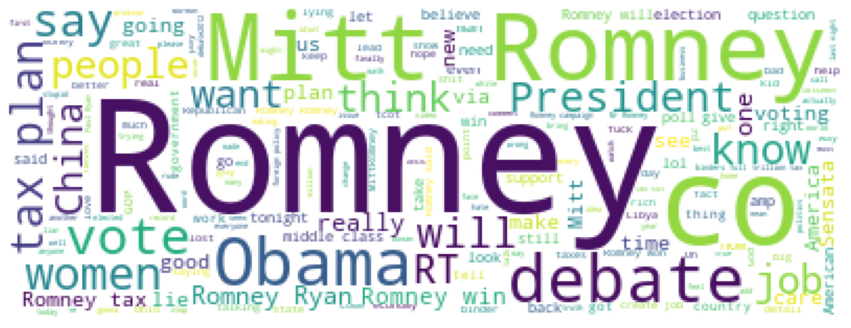

In [22]:
wordcloud(' '.join(tweets_rom))

['insidiousmitt romneys bain helped philip morris get us high schoolers hooked on cigarettes via '
 ' you mean like romney cheated in primary'
 'mitt romney still doesnt believe that we have a black president' ...
 'el  por ciento de las mujeres blancas casadas respaldan a romney'
 'and they brought us a whole binder of women oh romney' ' romneywon']


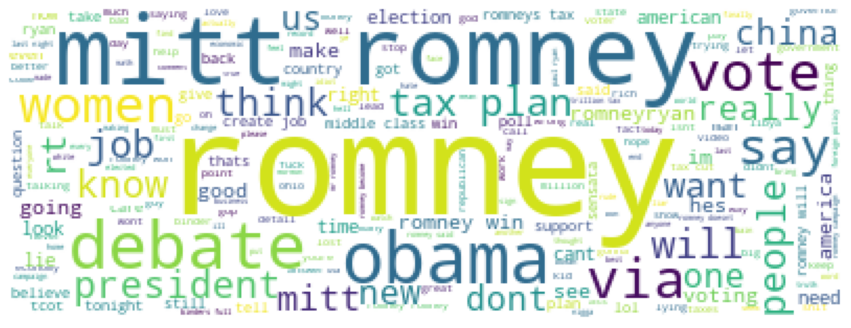

In [23]:
# Remove special char only
rom_rmspecial = tweet_cleaning(tweets_rom, '')
print(rom_rmspecial)
wordcloud(''.join(rom_rmspecial))

['insidiousmitt romney bain help philip morri get u high schooler hook on cigarett via'
 'you mean like romney cheat in primari'
 'mitt romney still doesnt believ that we have a black presid' ...
 'el por ciento de la mujer blanca casada respaldan a romney'
 'and they brought u a whole binder of woman oh romney' 'romneywon']


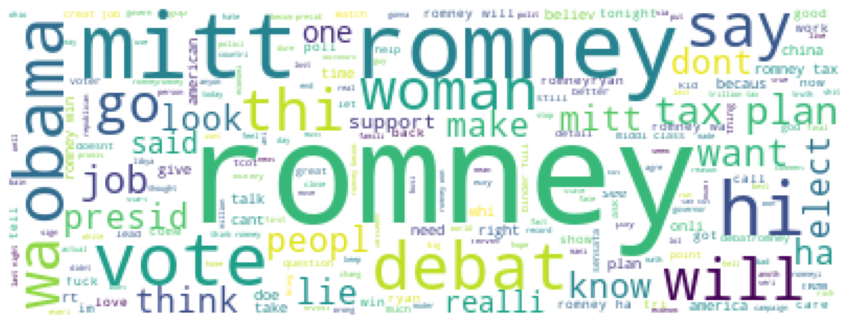

In [24]:
# Tweet stemmer_lemmatizer
rom_stemlem = tweet_cleaning(tweets_rom, 'stem_lem')
print(rom_stemlem)
wordcloud(''.join(rom_stemlem))

['insidiousmitt romney bain help philip morri get u high schooler hook cigarett via'
 'mean like romney cheat primari'
 'mitt romney still doesnt believ black presid' ...
 'el por ciento de la mujer blanca casada respaldan romney'
 'brought u whole binder woman oh romney' 'romneywon']


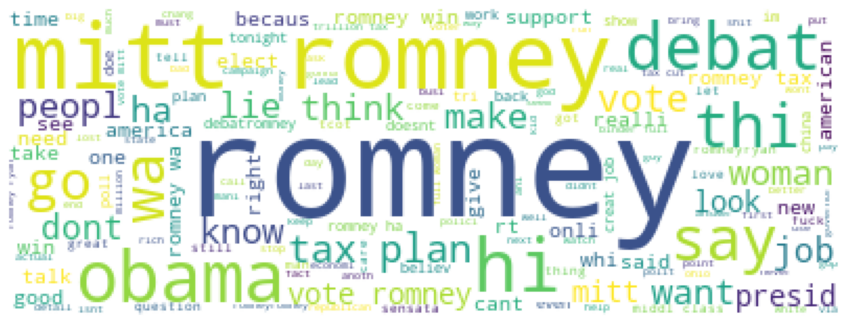

In [25]:
# Remove stopword
rom_rmstop = tweet_cleaning(tweets_rom, 'rm_stopwords')
print(rom_rmstop)
wordcloud(''.join(rom_rmstop))

['insidiousmitt romney bain help philip morri get u high schooler hook cigarett via'
 'mean like romney cheat primari'
 'mitt romney still doesnt believ black presid' ...
 'el por ciento de la mujer blanca casada respaldan romney'
 'brought u whole binder woman oh romney' 'romneywon']


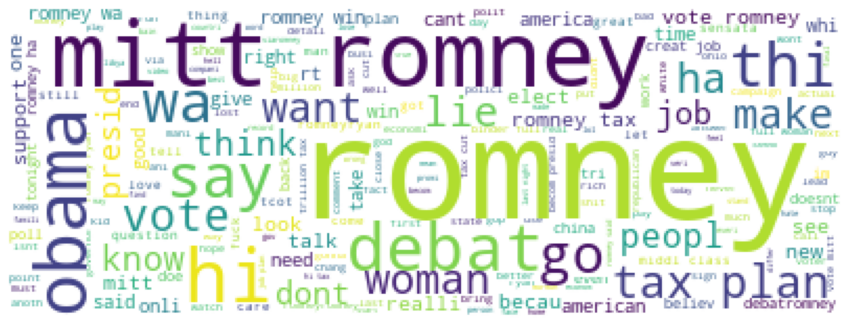

In [26]:
# All cleaning methods
rom_cleanall = tweet_cleaning(tweets_rom, 'all')
print(rom_cleanall)
wordcloud(''.join(rom_cleanall))

In [27]:
save_dataset(rom_cleanall, targets_rom, 'tweets_rom', 'targets_rom')

Saving training dataset...
Saved parsed dataset


### Data Info

In [28]:
import seaborn as sns
df = pd.DataFrame({'tweet':oba_cleanall, 'label': targets_oba })

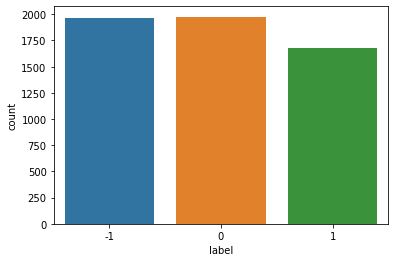

In [29]:
sns.countplot(df['label'])

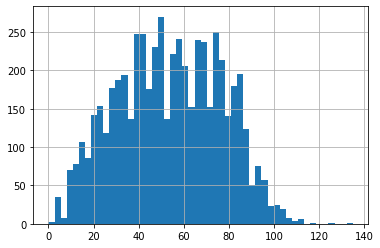

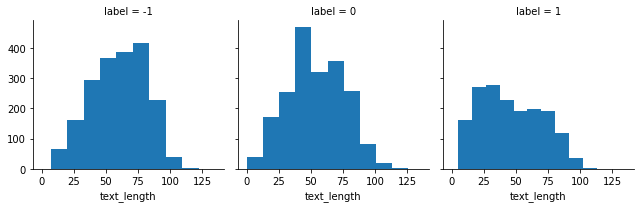

In [30]:
df['text_length'] = df['tweet'].apply(len)
df[['label','text_length','tweet']].head()
df['text_length'].describe()
df['text_length'].hist(bins=50)
g = sns.FacetGrid(df,col='label')
g.map(plt.hist,'text_length')

## Data Vectorization

In [31]:
train_X, test_X, train_Y, test_Y = train_test_split(oba_cleanall, targets_oba, test_size = 0.2, random_state = 42)

### TF-IDF vectorizer

In [32]:
#tfv = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')
tfv = TfidfVectorizer()
train_tfv = tfv.fit_transform(train_X)
test_tfv = tfv.transform(test_X)

In [33]:
vocab = tfv.get_feature_names()
print(vocab[:5])
print("Vocabulary length:", len(vocab))
dist = np.sum(train_tfv, axis=0)
checking = pd.DataFrame(dist, columns = vocab)
checking

['aa', 'aaaand', 'aaron', 'ab', 'abandon']
Vocabulary length: 6175


,aa,aaaand,aaron,ab,abandon,abba,abc,abcfox,abcpolit,abe,...,zerohedg,zesti,zien,zinger,zippedexcept,zipper,zombi,zwei,zzz,zzzzzzzzzz
0,0.433046,0.492133,0.309495,0.448678,1.127206,0.290708,5.77754,0.396907,0.409914,0.326947,...,0.481234,0.583062,0.262956,0.445127,0.391942,0.369544,0.922398,0.35337,0.586007,0.992812


In [34]:
tfv.idf_

array([8.7186855, 8.7186855, 8.7186855, ..., 8.7186855, 8.7186855,
       8.7186855])

### Count Vector

In [35]:
cv = CountVectorizer()
train_cv = cv.fit_transform(train_X)
test_cv = cv.transform(test_X)

In [36]:
cvocab = cv.get_feature_names()
print(cvocab[:5])

['aa', 'aaaand', 'aaron', 'ab', 'abandon']


### Train Models

##### MLP Classifier

In [37]:
MLP = MLPClassifier(random_state = 42)

mlp_param_grid = {
    'hidden_layer_sizes':[(5)],
    'activation':['relu'],
    'solver':['adam'],
    'alpha':[0.3],
    'learning_rate':['constant'],
    'max_iter':[1000]
}

kfold = StratifiedKFold( n_splits = 5, random_state = 42, shuffle=True )
gsMLP = GridSearchCV(MLP, param_grid = mlp_param_grid, cv = kfold, n_jobs= 1, verbose = 1)
gsMLP.fit(train_tfv, train_Y)
print(gsMLP.best_params_)
mlp_best0 = gsMLP.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'activation': 'relu', 'alpha': 0.3, 'hidden_layer_sizes': 5, 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.7s finished


In [38]:
gsMLP.best_score_
MLP_Y_predict = gsMLP.predict(test_tfv)
print("MLP Classifier - Training Result")
print(classification_report(gsMLP.predict(train_tfv),train_Y,digits=4))
print("MLP Classifier - Validation Result")
print(classification_report(MLP_Y_predict,test_Y, digits=4))


MLP Classifier - Training Result
              precision    recall  f1-score   support

          -1     0.9759    0.9680    0.9720      1593
           0     0.9508    0.9723    0.9614      1550
           1     0.9670    0.9513    0.9591      1356

    accuracy                         0.9644      4499
   macro avg     0.9646    0.9639    0.9642      4499
weighted avg     0.9646    0.9644    0.9644      4499

MLP Classifier - Validation Result
              precision    recall  f1-score   support

          -1     0.6314    0.5778    0.6034       424
           0     0.5026    0.5353    0.5184       368
           1     0.5536    0.5736    0.5634       333

    accuracy                         0.5627      1125
   macro avg     0.5625    0.5622    0.5618      1125
weighted avg     0.5662    0.5627    0.5638      1125



##### Logistic Regression

In [39]:
from sklearn import linear_model

logisticReg = linear_model.LogisticRegressionCV(cv=5, solver='lbfgs',class_weight='balanced', max_iter=10000)
logisticReg.fit(train_tfv, train_Y)

Y_lr_predict=logisticReg.predict(test_tfv)

print("Logistic Regression - Training Result")
print(classification_report(logisticReg.predict(train_tfv),train_Y,digits=4))
print("Logistic Regression - Validation Result")
print(classification_report(Y_lr_predict,test_Y, digits=4))

Logistic Regression - Training Result
              precision    recall  f1-score   support

          -1     0.8146    0.7748    0.7942      1661
           0     0.7363    0.7785    0.7568      1499
           1     0.7639    0.7610    0.7624      1339

    accuracy                         0.7719      4499
   macro avg     0.7716    0.7715    0.7711      4499
weighted avg     0.7734    0.7719    0.7723      4499

Logistic Regression - Validation Result
              precision    recall  f1-score   support

          -1     0.6186    0.5769    0.5970       416
           0     0.5357    0.5526    0.5440       380
           1     0.5768    0.6049    0.5905       329

    accuracy                         0.5769      1125
   macro avg     0.5770    0.5781    0.5772      1125
weighted avg     0.5784    0.5769    0.5772      1125



##### Linear Support Vector Classification

In [40]:
from sklearn import svm
clf = svm.LinearSVC(max_iter=2000)
clf.fit(train_tfv, train_Y)

LinearSVC(max_iter=2000)

In [41]:
clf_Y_predict = clf.predict(test_tfv)
print("Linear Support Vector Classification - Training Result")
print(classification_report(clf.predict(train_tfv),train_Y,digits=4))
print("Linear Support Vector Classification - Validation Result")
print(classification_report(clf_Y_predict,test_Y, digits=4))

Linear Support Vector Classification - Training Result
              precision    recall  f1-score   support

          -1     0.9620    0.9429    0.9524      1612
           0     0.9249    0.9557    0.9400      1534
           1     0.9438    0.9305    0.9371      1353

    accuracy                         0.9435      4499
   macro avg     0.9436    0.9430    0.9432      4499
weighted avg     0.9439    0.9435    0.9436      4499

Linear Support Vector Classification - Validation Result
              precision    recall  f1-score   support

          -1     0.6366    0.5812    0.6076       425
           0     0.5128    0.5346    0.5234       376
           1     0.5565    0.5926    0.5740       324

    accuracy                         0.5689      1125
   macro avg     0.5686    0.5694    0.5684      1125
weighted avg     0.5721    0.5689    0.5698      1125



##### Random Forest Classifier

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = RandomForestClassifier()
model.fit(train_tfv, train_Y)

y_rf_pred = model.predict(test_tfv)

print("Training Accuracy :", model.score(train_tfv, train_Y))
print("Validation Accuracy :", model.score(test_tfv, test_Y))

# calculating the f1 score for the validation set
#print("F1 score :", f1_score(test_Y, y_pred))

# confusion matrix
cm = confusion_matrix(test_Y, y_rf_pred)
print(cm)

print("Random Forest Classifier - Training Result")
print(classification_report(model.predict(train_tfv),train_Y,digits=4))

print("Random Forest Classifier - Validation Result")
print(classification_report(y_rf_pred,test_Y, digits=4))

Training Accuracy : 0.9919982218270726
Validation Accuracy : 0.5777777777777777
[[221 108  59]
 [ 88 225  79]
 [ 41 100 204]]
Random Forest Classifier - Training Result
              precision    recall  f1-score   support

          -1     0.9968    0.9937    0.9953      1585
           0     0.9842    0.9943    0.9892      1569
           1     0.9955    0.9874    0.9914      1345

    accuracy                         0.9920      4499
   macro avg     0.9922    0.9918    0.9920      4499
weighted avg     0.9920    0.9920    0.9920      4499

Random Forest Classifier - Validation Result
              precision    recall  f1-score   support

          -1     0.5696    0.6314    0.5989       350
           0     0.5740    0.5196    0.5455       433
           1     0.5913    0.5965    0.5939       342

    accuracy                         0.5778      1125
   macro avg     0.5783    0.5825    0.5794      1125
weighted avg     0.5779    0.5778    0.5768      1125



##### Decision Tree Classifier

In [43]:
model = DecisionTreeClassifier()
model.fit(train_tfv, train_Y)

y_dt_pred = model.predict(test_tfv)

print("Training Accuracy :", model.score(train_tfv, train_Y))
print("Validation Accuracy :", model.score(test_tfv, test_Y))

# calculating the f1 score for the validation set
#print("F1 score :", f1_score(test_Y, y_pred))

# confusion matrix
cm = confusion_matrix(test_Y, y_dt_pred)
print(cm)

print("Training Result")
print(classification_report(model.predict(train_tfv), train_Y, digits=4))

print("Decision Tree Classifier")
print(classification_report(y_dt_pred,test_Y, digits=4))

Training Accuracy : 0.9919982218270726
Validation Accuracy : 0.48
[[177 126  85]
 [101 185 106]
 [ 75  92 178]]
Training Result
              precision    recall  f1-score   support

          -1     0.9981    0.9924    0.9953      1589
           0     0.9849    0.9936    0.9892      1571
           1     0.9933    0.9895    0.9914      1339

    accuracy                         0.9920      4499
   macro avg     0.9921    0.9919    0.9920      4499
weighted avg     0.9920    0.9920    0.9920      4499

Decision Tree Classifier
              precision    recall  f1-score   support

          -1     0.4562    0.5014    0.4777       353
           0     0.4719    0.4591    0.4654       403
           1     0.5159    0.4824    0.4986       369

    accuracy                         0.4800      1125
   macro avg     0.4814    0.4810    0.4806      1125
weighted avg     0.4814    0.4800    0.4802      1125



##### Linear Support Vector Classification

In [44]:
from sklearn.svm import SVC

model = SVC()
model.fit(train_tfv, train_Y)

y_pred = model.predict(test_tfv)

print("Training Accuracy :", model.score(train_tfv, train_Y))
print("Validation Accuracy :", model.score(test_tfv, test_Y))

# calculating the f1 score for the validation set
#print("F1 score :", f1_score(test_Y, y_pred))

# confusion matrix
cm = confusion_matrix(test_Y, y_pred)
print(cm)

Training Accuracy : 0.9586574794398756
Validation Accuracy : 0.5964444444444444
[[263  89  36]
 [115 224  53]
 [ 66  95 184]]


In [45]:
kfold = StratifiedKFold( n_splits = 5, random_state = 42, shuffle=True )
print(kfold)
sv = LinearSVC(random_state=2018)

param_grid2 = {
    'loss':['squared_hinge'],
    'class_weight':[{1:4}],
    'C': [0.2]
}
sv.fit(train_tfv, train_Y)
accuracy_score(test_Y, sv.predict(test_tfv))

StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


0.5688888888888889

##### Gaussian Naive Bayes

In [46]:
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([
    ('clf', MultinomialNB())
])

parameters = {
    'clf__priors': [None],
    'clf__var_smoothing': [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
}

cv = GridSearchCV(pipeline, param_grid=parameters, scoring='accuracy')

# gnb = GaussianNB()
mnb = MultinomialNB()
Y_pred_Bayes = mnb.fit(train_tfv.toarray(), train_Y).predict(test_tfv.toarray())
# print(cv.best_params_)
# print(cv.best_score_)
print("Gaussian Naive Bayes - Training Result")
print(classification_report(mnb.predict(train_tfv.toarray()), train_Y, digits=4))
print("Gaussian Naive Bayes - Validation Result")
print(classification_report(Y_pred_Bayes,test_Y, digits=4))

Gaussian Naive Bayes - Training Result
              precision    recall  f1-score   support

          -1     0.9203    0.7705    0.8388      1887
           0     0.7691    0.8720    0.8173      1398
           1     0.7931    0.8715    0.8305      1214

    accuracy                         0.8293      4499
   macro avg     0.8275    0.8380    0.8288      4499
weighted avg     0.8390    0.8293    0.8299      4499

Gaussian Naive Bayes - Validation Result
              precision    recall  f1-score   support

          -1     0.7320    0.5420    0.6228       524
           0     0.4770    0.5599    0.5152       334
           1     0.5101    0.6592    0.5752       267

    accuracy                         0.5751      1125
   macro avg     0.5730    0.5870    0.5710      1125
weighted avg     0.6036    0.5751    0.5795      1125



##### XGBoost

In [47]:
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3)
xgb.fit(train_tfv, train_Y)
xgb_Y_predict = xgb.predict(test_tfv)
print("XGBoost - Training Result")
print(classification_report(xgb.predict(train_tfv),train_Y,digits=4))
print("XGBoost - Validation Result")
print(classification_report(xgb_Y_predict,test_Y, digits=4))

XGBoost - Training Result
              precision    recall  f1-score   support

          -1     0.9880    0.9943    0.9911      1570
           0     0.9811    0.9848    0.9829      1579
           1     0.9888    0.9770    0.9829      1350

    accuracy                         0.9858      4499
   macro avg     0.9859    0.9854    0.9856      4499
weighted avg     0.9858    0.9858    0.9858      4499

XGBoost - Validation Result
              precision    recall  f1-score   support

          -1     0.5515    0.5530    0.5523       387
           0     0.4847    0.4974    0.4910       382
           1     0.5855    0.5674    0.5763       356

    accuracy                         0.5387      1125
   macro avg     0.5406    0.5393    0.5398      1125
weighted avg     0.5396    0.5387    0.5391      1125



In [48]:
adb = AdaBoostClassifier(SVC(probability=True,kernel='linear'),n_estimators=50,learning_rate=1.0,algorithm='SAMME.R')
adb.fit(train_tfv, train_Y)

AdaBoostClassifier(base_estimator=SVC(kernel='linear', probability=True))

In [49]:
adb_Y_predict = adb.predict(test_tfv)
print("AdaBoost SVM - Training Result")
print(classification_report(adb.predict(train_tfv),train_Y,digits=4))
print("AdaBoost SVM- Validation Result")
print(classification_report(adb_Y_predict,test_Y, digits=4))

AdaBoost SVM - Training Result
              precision    recall  f1-score   support

          -1     0.8956    0.8597    0.8772      1646
           0     0.8637    0.7028    0.7750      1948
           1     0.6327    0.9326    0.7539       905

    accuracy                         0.8064      4499
   macro avg     0.7973    0.8317    0.8020      4499
weighted avg     0.8289    0.8064    0.8082      4499

AdaBoost SVM- Validation Result
              precision    recall  f1-score   support

          -1     0.5722    0.5904    0.5812       376
           0     0.6684    0.4764    0.5563       550
           1     0.3913    0.6784    0.4963       199

    accuracy                         0.5502      1125
   macro avg     0.5439    0.5817    0.5446      1125
weighted avg     0.5872    0.5502    0.5540      1125



In [50]:
Y_pred_list = np.array(([MLP_Y_predict], [clf_Y_predict], [y_rf_pred], [y_dt_pred], [Y_pred_Bayes], [Y_lr_predict]))
Y_pred_title_list = ['MLP Classifier', 'SVM', 'Random Forest', 'Decision Tree', 'Gaussian Naive Bayes', 'Logistic Regression']
# print(classification_report(Y_lr_predict, MLP_Y_predict))
for i in range(len(Y_pred_list)):
    for j in range(len(Y_pred_list)-i-1):
        print(Y_pred_title_list[i] +" v.s. "+  Y_pred_title_list[i+j+1])
        print(classification_report(Y_pred_list[i][0], Y_pred_list[i+j+1][0]))

MLP Classifier v.s. SVM
              precision    recall  f1-score   support

          -1       0.95      0.95      0.95       424
           0       0.92      0.94      0.93       368
           1       0.95      0.93      0.94       333

    accuracy                           0.94      1125
   macro avg       0.94      0.94      0.94      1125
weighted avg       0.94      0.94      0.94      1125

MLP Classifier v.s. Random Forest
              precision    recall  f1-score   support

          -1       0.75      0.62      0.68       424
           0       0.60      0.70      0.65       368
           1       0.68      0.70      0.69       333

    accuracy                           0.67      1125
   macro avg       0.68      0.67      0.67      1125
weighted avg       0.68      0.67      0.67      1125

MLP Classifier v.s. Decision Tree
              precision    recall  f1-score   support

          -1       0.58      0.48      0.53       424
           0       0.50      0.55    